In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp
import jax.lax as lax
import jax_cosmo as jc

In [3]:
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import flowpm.scipy.interpolate as interpolate

In [4]:
from jaxpm.kernels import *
from jaxpm.painting import *
from jaxpm.growth import *

In [5]:
# Below are a few parameters
box_size = [100.,100., 100.]   # Transverse comoving size of the simulation volume
nc = [100, 100, 100]           # Number of transverse voxels in the simulation volume
batch_size = 1                 # Number of simulations to run in parallel

In [6]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()

# Create some initial conditions
k = tf.constant(np.logspace(-4, 1, 128), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(nc,
                                      box_size, 
                                      pk_fun,         
                                      batch_size=batch_size)

initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1, order=1)

2022-02-14 00:21:13.509002: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-02-14 00:21:13.509025: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-02-14 00:21:13.509034: W tensorflow/stream_executor/stream.cc:1260] attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: BlasScal failed : in.shape=[1,100,100,100] [Op:IFFT3D]

In [7]:
@tf.function
def solve_tf(init_state):
    final_state = flowpm.nbody(cosmology, initial_state, linspace(0.1,1.,40), nc)
    return final_state

In [8]:
final_state = solve_tf(initial_state)

In [29]:
%timeit final_state = solve_tf(initial_state)

1.3 s ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


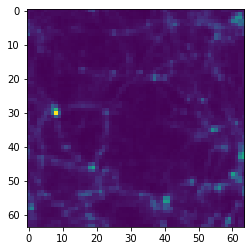

In [9]:
imshow(flowpm.cic_paint(tf.zeros([1]+nc), final_state[0]).numpy()[0].sum(axis=0))

In [7]:
mesh_shape = nc
kvec = fftk(mesh_shape)

In [26]:
# We need the vel and forces from lpt
def lpt1(delta_k, pos):   
    pot_k = delta_k * laplace_kernel(kvec)
    return jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) for i in range(3)],axis=-1)
    
def lpt(cosmo, linear, pos, a):
    delta_k = jnp.fft.rfftn(linear)
    a = jnp.atleast_1d(a)
    lpt_dx = lpt1(delta_k, pos)
    dx = growth_factor(cosmo, a) * lpt_dx
    p = a**2 * growth_rate(cosmo, a) * jnp.sqrt(jc.background.Esqr(cosmo, a)) * dx
    f = a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a)) * dGfa(cosmo, a) / growth_factor(cosmo, a) * dx
    return lpt_dx, dx, p, f

In [27]:
pos0 = jnp.stack(jnp.meshgrid(jnp.arange(100), jnp.arange(100), jnp.arange(100)), axis=-1).reshape([-1,3])

In [30]:
lpt_dx, x, p,f = lpt(jc.Planck15(), initial_conditions[0].numpy(), pos0, 1.)

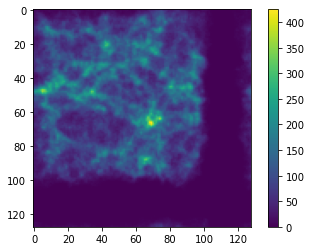

In [31]:
imshow(cic_paint(jnp.zeros(mesh_shape), pos0+x).sum(axis=0)); colorbar()

In [13]:
# Define the ODE
def f(state, a, cosmo, lpt_dx):
    # Extracts positions and velocity at a given point in
    # the simulation
    res_pos, res_vel = state
    a =  jnp.atleast_1d(a)
    pos = pos0 + growth_factor(cosmo, a) * lpt_dx + res_pos
    
    # Computes the potential given the current positions
    delta_k = jnp.fft.rfftn(cic_paint(jnp.zeros(mesh_shape), pos))
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec,r_split=0)
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    forces = forces * 1.5 * cosmo.Omega_m
    
    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * res_vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces - dGfa(cosmo, a) * lpt_dx
    
    return dpos, dvel

In [14]:
import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController

In [15]:
cosmo = jc.Planck15()

def f_diffrax(t, state, args):
    return jnp.stack(f(state, t, cosmo, lpt_dx),axis=0)


term = ODETerm(f_diffrax)
solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

In [31]:
init_state = jnp.stack([jnp.zeros((100,100,100,3)).reshape((-1,3)),
              jnp.zeros((100,100,100,3)).reshape((-1,3))], axis=0)

solution = diffeqsolve(term, solver, t0=0.1, t1=1., dt0=0.1,
                       y0=init_state, stepsize_controller=stepsize_controller)

/home/francois/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:6655: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


(1000000, 8)
(1000000, 8)
(1000000, 8)
(1000000, 8)
(1000000, 8)
(1000000, 8)
(1000000, 8)
(1000000, 8)


2022-02-14 00:10:24.488749: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2124] Execution of replica 0 failed: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory


RuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [26]:
%timeit solution = diffeqsolve(term, solver, t0=0.1, t1=1., dt0=0.1, y0=init_state+0, stepsize_controller=stepsize_controller)

421 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
solution

Solution(t0=DeviceArray(0.1, dtype=float32), t1=DeviceArray(1., dtype=float32), ts=DeviceArray([1.], dtype=float32, weak_type=True), ys=DeviceArray([[[[-0.05698265, -0.4233138 , -0.23527317],
               [-0.4048839 , -0.18278353,  0.10613398],
               [-0.39811632,  0.36003193,  0.5207157 ],
               ...,
               [-0.12596521,  0.04650298,  0.12780993],
               [ 0.10532238,  0.22021866, -0.00881826],
               [ 0.21299808,  0.42117628, -0.05347536]],

              [[-0.07113229, -0.40208206, -0.18125573],
               [-0.3594675 , -0.14042078,  0.1074788 ],
               [-0.29909593,  0.34923548,  0.42418486],
               ...,
               [-0.2394397 ,  0.07868364,  0.09896102],
               [ 0.06142797,  0.22736594,  0.05615562],
               [ 0.18805356,  0.38284227, -0.00324537]]]],            dtype=float32, weak_type=True), interpolation=None, stats={'compiled_num_steps': None, 'max_steps': 4096, 'num_accepted_steps': DeviceAr

In [23]:
solution.ys.shape

(1, 2, 1000000, 3)

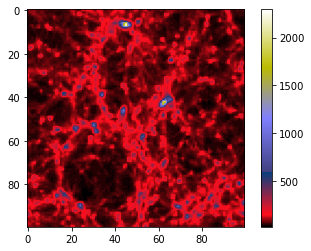

In [25]:
resx = solution.ys[0,0]+pos0+x
imshow(cic_paint(jnp.zeros(mesh_shape), resx).sum(axis=0),cmap='gist_stern'); colorbar()

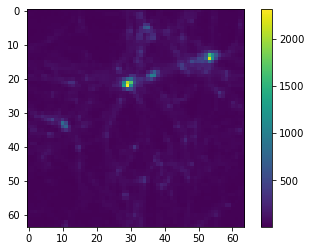

In [57]:
imshow((flowpm.cic_paint(tf.zeros([1]+mesh_shape), final_state[0]).numpy()[0]).sum(axis=0)); colorbar()

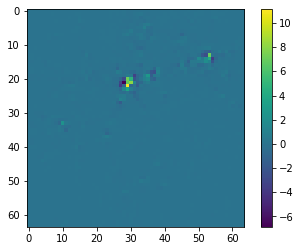

In [58]:
imshow((cic_paint(jnp.zeros(mesh_shape), resx) - 
        flowpm.cic_paint(tf.zeros([1]+mesh_shape), final_state[0]).numpy()[0]).sum(axis=0)); colorbar()

In [35]:
from jax.experimental.ode import odeint

In [39]:
init_state = [jnp.zeros((64,64,64,3)).reshape((-1,3)),
              jnp.zeros((64,64,64,3)).reshape((-1,3))]

@jax.jit
def solve_ode(init_state):
    cosmo = jc.Planck15()
    return odeint(f, init_state, 
             jnp.linspace(0.1,1.0,10), 
             cosmo,
             lpt_dx, rtol=1e-5, atol=1e-5)

In [37]:
res = solve_ode(init_state)

In [38]:
%timeit res = solve_ode(init_state)

765 ms ± 7.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


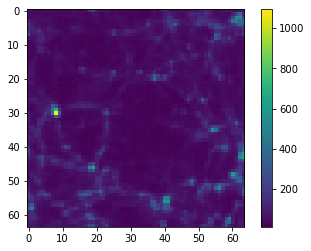

In [22]:
resx = res[0][-1]+pos0+x
imshow(cic_paint(jnp.zeros(mesh_shape), resx).sum(axis=0)); colorbar()

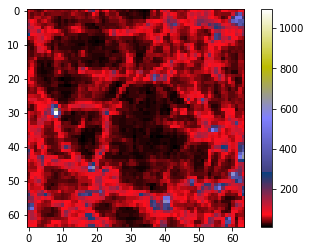

In [23]:
imshow((flowpm.cic_paint(tf.zeros([1]+mesh_shape), final_state[0]).numpy()[0]).sum(axis=0),cmap='gist_stern'); colorbar()

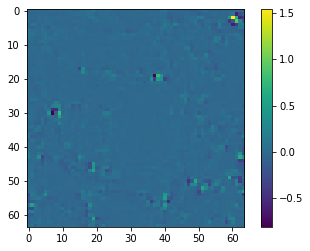

In [24]:
imshow((cic_paint(jnp.zeros(mesh_shape), resx) - 
        flowpm.cic_paint(tf.zeros([1]+mesh_shape), final_state[0]).numpy()[0]).sum(axis=0)); colorbar()

In [25]:
from DifferentiableHOS.pk import power_spectrum

In [26]:
k, pk = power_spectrum(flowpm.cic_paint(tf.zeros([1]+mesh_shape), final_state[0]),
                       boxsize=array([64.,64.,64.]),                      
                       kmin=0.1,dk=2*np.pi/64.)

k, pk_jax = power_spectrum(tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), resx).reshape([1,64,64,64])),
                       boxsize=array([64.,64.,64.]),                      
                       kmin=0.1,dk=2*np.pi/64.)


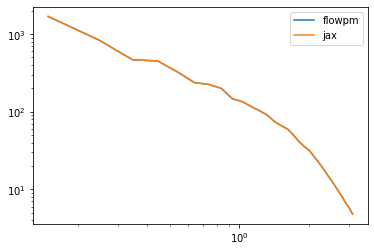

In [27]:
loglog(k,pk[0], label='flowpm')
loglog(k,pk_jax[0], label='jax')
legend()

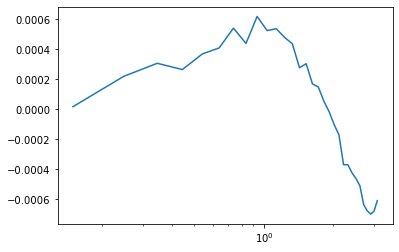

In [28]:
semilogx(k,(pk_jax[0] - pk[0])/pk[0])